### Import modules 

In [1]:
# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras callbacks
# from keras.layers import Input, Dense
# from keras.models import Model, load_model
# from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# other
import time


# AutoEncoders for Event Detection (AEED)
from aeed import AEED, load_AEED

Using TensorFlow backend.


### Load and preprocess training data

In [2]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [3]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)

### Train autoencoder

In [4]:
# define model parameters
params = {
    'nI' : X.shape[1],
    'nH' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,
}

# create AutoEncoder for Event Detection (AEED)
autoencoder = AEED(**params)
autoencoder.initialize()

Created autoencoder with structure:
layer_0: 43, layer_1: 34, layer_2: 25, layer_3: 17, layer_4: 25, layer_5: 34, layer_6: 43


In [5]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
    
# initialize time
start_time = time.time()

# train autoencoder
autoencoder.train(X1.values,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(X2.values, X2.values))



Train on 5869 samples, validate on 2892 samples
Epoch 1/500
 - 5s - loss: 0.0925 - val_loss: 0.0370
Epoch 2/500
 - 1s - loss: 0.0225 - val_loss: 0.0134
Epoch 3/500
 - 1s - loss: 0.0116 - val_loss: 0.0095
Epoch 4/500
 - 1s - loss: 0.0089 - val_loss: 0.0077
Epoch 5/500
 - 1s - loss: 0.0072 - val_loss: 0.0063
Epoch 6/500
 - 1s - loss: 0.0056 - val_loss: 0.0049
Epoch 7/500
 - 1s - loss: 0.0045 - val_loss: 0.0041
Epoch 8/500
 - 1s - loss: 0.0038 - val_loss: 0.0035
Epoch 9/500
 - 1s - loss: 0.0032 - val_loss: 0.0029
Epoch 10/500
 - 1s - loss: 0.0026 - val_loss: 0.0024
Epoch 11/500
 - 1s - loss: 0.0022 - val_loss: 0.0020
Epoch 12/500
 - 1s - loss: 0.0019 - val_loss: 0.0018
Epoch 13/500
 - 1s - loss: 0.0017 - val_loss: 0.0016
Epoch 14/500
 - 1s - loss: 0.0016 - val_loss: 0.0015
Epoch 15/500
 - 1s - loss: 0.0015 - val_loss: 0.0015
Epoch 16/500
 - 1s - loss: 0.0015 - val_loss: 0.0014
Epoch 17/500
 - 1s - loss: 0.0014 - val_loss: 0.0013
Epoch 18/500
 - 1s - loss: 0.0013 - val_loss: 0.0013
Epoch 1

### Test autoencoder

In [6]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat)]

In [7]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']

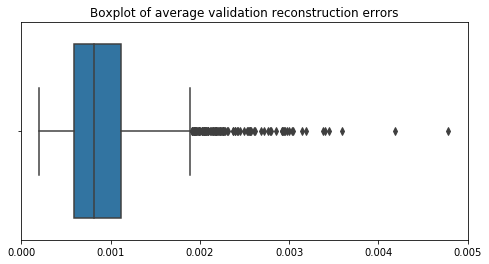

In [8]:
# perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.995)

Yhat3, _ = autoencoder.detect(X3, theta = theta , window = 3, average=True)
Yhat4, _ = autoencoder.detect(X4, theta = theta, window = 3, average=True)

In [9]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall
test dataset 01  0.941585  0.730684  0.799517  0.672764
test dataset 02  0.923887   0.77886  0.897436  0.687961


[Text(0,0,'NO ATTACK'), Text(0,0,'ATTACK')]

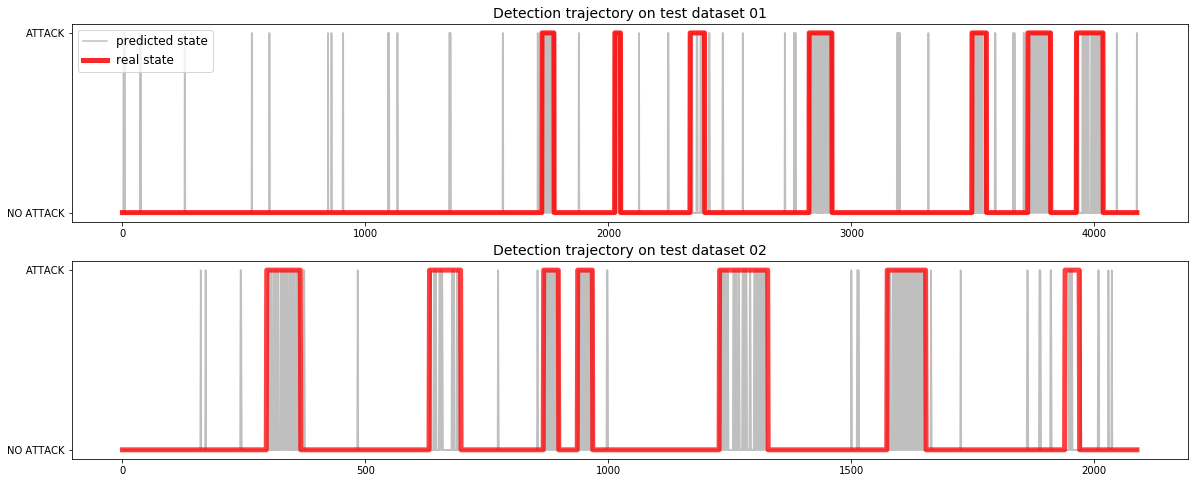

In [10]:
# plot figures
shade_of_gray = '0.75'
f, axes = plt.subplots(2,figsize = (20,8))
axes[0].plot(Yhat3, color = shade_of_gray, label = 'predicted state')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Y3, color = 'r', alpha = 0.85, lw = 5, label = 'real state')
axes[0].set_title('Detection trajectory on test dataset 01', fontsize = 14)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
axes[0].legend(fontsize = 12, loc = 2)

axes[1].plot(Yhat4, color = shade_of_gray, label = 'predicted state')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
axes[1].plot(Y4, color = 'r', alpha = 0.75, lw = 5, label = 'real state')
axes[1].set_title('Detection trajectory on test dataset 02', fontsize = 14)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

In [11]:
# save autoencoder
autoencoder.save('autoencoder')
del autoencoder

Saved AEED parameters to autoencoder.json.
Keras model saved to autoencoder.h5


### Compare ROC curves

In [12]:
# load autoencoder
autoencoder = load_AEED('autoencoder.json','autoencoder.h5')

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)

In [13]:
def compute_roc_curve(X, Y, window, quantiles, verbose = False):    
    print('Computing ROC curve for window = %d'%(window))    
    df_roc = pd.DataFrame(index = quantiles, columns = ['fpr','tpr'])
    for qtile in quantiles:
        # compute results
        theta = validation_errors.mean(axis = 1).quantile(qtile)
        if verbose:
            print('Quantile: {0:.3f}, threshold value: {1:.5}'.format(qtile,theta))
        Yhat, _ = autoencoder.detect(X, theta = theta, window = window, average=True)
        CM = confusion_matrix(Y,Yhat)
        TN = CM[0,0]
        FP = CM[0,1]
        FN = CM[1,0]
        TP = CM[1,1]        
        fpr = FP/(FP+TN)
        tpr = TP/(TP+FN) # or recall_score, same stuff
        df_roc.loc[qtile,:] = [fpr, tpr]

    # compute auc
    df_roc.loc[0,:] = (1,1)
    df_roc.loc[1000,:] = (0,0)    
    area = auc(df_roc['fpr'],df_roc['tpr'], reorder =True)
        
    return df_roc.sort_index(), area


Computing ROC curve for window = 1
Computing ROC curve for window = 3
Computing ROC curve for window = 6
Computing ROC curve for window = 12


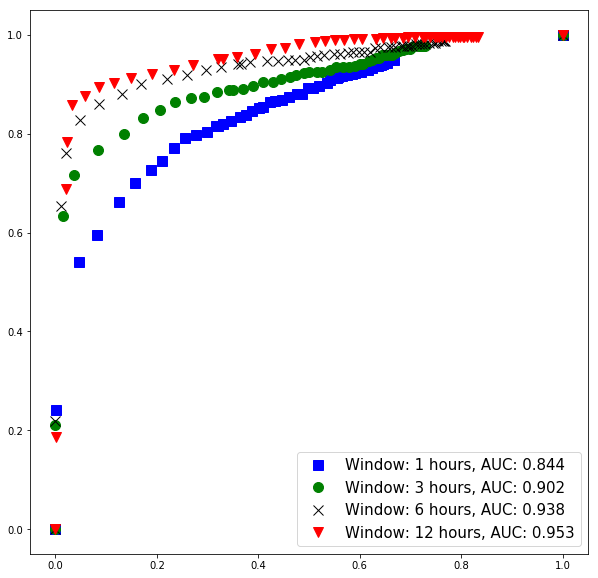

In [14]:
windows = [1,3,6,12]
colors = ['blue', 'green', 'black', 'red']
markers = ['s','o','x','v']

thresholds = np.linspace(0.8,1,51)
f, ax = plt.subplots(1,figsize=(10,10))
for window, color, marker in zip(windows,colors,markers):
    df_roc, area = compute_roc_curve(X3, Y3, window, thresholds)
    ax.plot(df_roc.fpr, df_roc.tpr,color = color, lw = 0, linestyle = None, 
        marker = marker, markersize = 10, markerfacecolor = color, 
            label='Window: {0:d} hours, AUC: {1:.3f}'.format(window,area))
ax.legend(fontsize = 15)
